# Overlap finemapped GWAS signals with ATAC-seq peaks and TFBS footprints
- only credible sets with <= 50 variants

In [1]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [2]:
dir.create("pipeline/6.2.footprints_finemap"                    , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect"          , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect/input"    , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect/output"   , showWarnings = FALSE)
dir.create("pipeline/6.2.footprints_finemap/intersect/processed", showWarnings = FALSE)


In [3]:
loci             = add_rownames(fread  ("pipeline/1.2.genomewide_significant_loci/loci.txt"          , sep = "\t", header = TRUE, data.table = FALSE))
manifest         = add_rownames(fread  ("pipeline/1.1.sumstats/manifest.txt"                         , sep = "\t", header = TRUE, data.table = FALSE))
moloc_df         =              fread  ("pipeline/2.2.moloc/moloc.txt"                               , sep = "\t", header = TRUE, data.table = FALSE)
locus2coloc      =              fread  ("pipeline/5.4.analyze_coloc_qtl_som_maps/signal2coloc.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
cs50             = locus2coloc[ locus2coloc$credible_set <= 50 & locus2coloc$finemapped == TRUE,]
meta_list        = lapply(cs50$id, function(id){readRDS(paste0("pipeline/5.5.meta_analysis/coloc_data/", id, ".rds"))})
names(meta_list) = cs50$id

# TFBS motifs

In [4]:
motifs       = fread("/frazer01/projects/CARDIPS/analysis/footprint_eqtl/jaspar/exp_gene.txt", sep = "\t", header = TRUE, data.table = FALSE)
motifs$motif = paste(motifs$base_id, motifs$version, sep = ".")

In [5]:
tfbs_folder    = "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif"
tfbs           = data.frame(infile = list.files(tfbs_folder, recursive = FALSE, full.names = FALSE),
                            motif  = ""
                           )
tfbs           = tfbs[grepl("txt.txt", tfbs$infile) == FALSE,]
tfbs$motif     = gsub("\\.txt", "", unlist(lapply(tfbs$infile, function(x){unlist(strsplit(x, "_"))[[2]]})))
tfbs$infile    = paste(tfbs_folder, tfbs$infile, sep = "/")
tfbs           = merge(tfbs, motifs, all = FALSE)
tfbs$bed       = paste0("pipeline/6.2.footprints_finemap/intersect/input/"    , tfbs$motif, ".bed")
tfbs$int       = paste0("pipeline/6.2.footprints_finemap/intersect/output/"   , tfbs$motif, ".txt")
tfbs$processed = paste0("pipeline/6.2.footprints_finemap/intersect/processed/", tfbs$motif, ".txt")

tfbs = rbind(tfbs, data.frame(motif     = "atac", 
                              infile    = "/frazer01/reference/private/CARDIPS/ATAC-Seq/CVPC/broad_peaks_PF.broadPeak", 
                              base_id   = "atac",
                              version   = 1,
                              id        = "atac",
                              name      = "ATAC",
                              prot_acc  = "",
                              gene_id   = "",
                              gene_name = "",
                              bed       = "pipeline/6.2.footprints_finemap/intersect/input/atac.bed", 
                              int       = "pipeline/6.2.footprints_finemap/intersect/output/atac.txt",
                              processed = "pipeline/6.2.footprints_finemap/intersect/processed/atac.txt"
                             ))

fwrite(tfbs, "pipeline/6.2.footprints_finemap/tfbs.txt", sep = "\t", col.names = TRUE, row.names = FALSE)
rownames(tfbs) = tfbs$motif


In [6]:
prepare_tfbs = function(motif, tfbs, threshold_exp = 0.2)
{
    if(motif == "atac"){has_header = FALSE}
    
    in_file               = tfbs[motif, "infile"]
    bed_file              = tfbs[motif, "bed"   ]
    has_header            = TRUE
    indata                = fread (in_file, sep = "\t", header = has_header, data.table = FALSE)
    indata                = indata[indata[,1] %in% paste0("chr", 1:22),]
    indata[,1]            = as.numeric(sub("chr", "", indata[,1]))
    colnames(indata)[1:3] = c("chrom", "from", "to")
    
    if(motif == "atac")
    {
        indata$exp   = 1
        indata$peak  = paste(indata$chrom, indata$from, indata$to, sep = "_")
    }else
    {
        indata$exp   = rowMeans(indata[, 10:ncol(indata)])
        indata$peak  = paste(indata$peak_chr, indata$peak_start, indata$peak_end, sep = "_")
    }
    
    indata       = indata[ indata$exp >= 0.2,]
    indata$coord = paste(indata$chrom, indata$from, indata$to, sep = "_")

    fwrite(indata[order(indata[,1], indata[,2], indata[,3]), c("chrom", "from", "to", "coord", "peak", "exp")], bed_file, sep = "\t", col.names = FALSE, row.names = FALSE)
}

invisible(lapply(tfbs$motif, function(motif){prepare_tfbs(motif, tfbs)}))


# Prepare BED file with fine mapped variants

In [7]:
prepare_credible_sets = function(signal_id, meta_list)
{
    #message(signal_id)
    credible_set = meta_list[[signal_id]][["finemapped_gwas"]][["credible_set"]]
    pps          = meta_list[[signal_id]][["finemapped_gwas"]][["pp"          ]]
    credible_set = credible_set[credible_set != "null"]
    
    chrom   = as.numeric(unlist(lapply(credible_set, function(x){unlist(strsplit(x, "_"))[[2]]})))
    pos     = as.numeric(unlist(lapply(credible_set, function(x){unlist(strsplit(x, "_"))[[3]]})))
    out     = merge(data.frame(chrom = chrom, pos = pos, id = credible_set, signal_id = signal_id, cs_rank = 1:length(credible_set)), pps)
    out$cs  = NULL
    out$cum = NULL
    
    return(out)
}

#signal_id = "1_2592477_2853372.1"
#prepare_credible_sets(signal_id, meta_list)

credible_sets     = as.data.frame(rbindlist(lapply(cs50$id, function(signal_id){prepare_credible_sets(signal_id, meta_list)})), stringsAsFactors = FALSE)
credible_sets_bed = "pipeline/6.2.footprints_finemap/intersect/credible_sets.bed"
credible_sets     = credible_sets[order(credible_sets$chrom, credible_sets$pos),]

fwrite(credible_sets, "pipeline/6.2.footprints_finemap/intersect/credible_sets.txt"  , sep = "\t", col.names = TRUE , row.names = FALSE)
fwrite(credible_sets[,c("chrom", "pos", "pos", "id", "signal_id")], credible_sets_bed, sep = "\t", col.names = FALSE, row.names = FALSE)


## Add consequence to credible set variants

In [8]:
snps       = fread(cmd = "zcat /frazer01/reference/public/ukbb/variants.tsv.bgz", sep = "\t", header = TRUE, data.table = FALSE)
snps       = snps[snps$chr %in% as.character(1:22),]
snps$chrom = as.numeric(snps$chr)
snps$id    = paste("VAR", snps$chrom, snps$pos, snps$ref, snps$alt, sep = "_")

In [9]:
snps$id = paste("VAR", snps$chrom, snps$pos, snps$ref, snps$alt, sep = "_")

In [10]:
cs_annot = merge(credible_sets, snps[,c("id", "rsid", "consequence", "consequence_category", "AF")], all.x = TRUE)

cs_annot[ is.na(cs_annot$consequence), "consequence_category"] = "non_coding"
cs_annot[ is.na(cs_annot$consequence), "consequence"         ] = "intergenic_variant"

fwrite(cs_annot, "pipeline/6.2.footprints_finemap/credible_sets_50_annotated.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# Intersect credible set variants with motifs

In [11]:
intersect_credible_set = function(motif, tfbs, credible_sets_bed, credible_sets)
{
    #message(motif)
    bed_file   = tfbs[motif, "bed"      ]
    out_file   = tfbs[motif, "int"      ]
    processed  = tfbs[motif, "processed"]
    command    = paste("bedtools", "closest", "-d", "-t", "all", "-a", credible_sets_bed, "-b", bed_file, ">", out_file)
    
    system(command)
    
    indata           = fread(out_file, sep = "\t", header = FALSE, data.table = FALSE)[,c(4,5,7:12)]
    colnames(indata) = c("id", "signal_id", "from", "to", "tfbs_coord", "peak", "tfbs_bound", "distance")
    indata           = merge(indata, credible_sets, by = c("id", "signal_id"))
    indata$motif     = motif
    out              = indata[,c("id", "signal_id", "chrom", "pos", "pval", "pp_snp", "cs_rank", "motif", "tfbs_coord", "peak", "tfbs_bound", "from", "to", "distance")]
    out$overlap      = 0
    out$distance100  = 0

    if(nrow(out[out$distance == 0,]) > 0)
    {
        out[out$distance == 0, "overlap"] = 1
    }
    if(nrow(out[out$distance <= 100,]) > 0)
    {
        out[out$distance <= 100, "distance100"] = 1
    }
    
    fwrite(out, processed, sep = "\t", col.names = TRUE, row.names = FALSE)
    
    return(out)
}

#motif = "MA0002.2"
#intersect_credible_set(motif, tfbs, credible_sets_bed, credible_sets)

cs2motif_list        = lapply(tfbs$motif, function(motif){intersect_credible_set(motif, tfbs, credible_sets_bed, credible_sets)})
names(cs2motif_list) = tfbs$motif

saveRDS(cs2motif_list, "pipeline/6.2.footprints_finemap/cs2motif_list.rds")


# Tests
- variants with high PPA are more likely to overlap active TFBS (bound in >20% samples)
- for each signal, is the variant with the highest PPA more likely to overlap an active TFBS?
- for each signal, is the variant with the highest PPA the closest to an active TFBS?
- how many signals have their credible set variants overlapping active TFBS?


## variants with high PPA are more likely to overlap active TFBS (bound in >20% samples)
- YES

In [372]:
test_pp = function(indata, x)
{
    indata$x = indata[,x]
    
    fit = as.data.frame(summary(lm(pp_snp ~ x, data = indata))$coefficients)
    
    if("x" %in% rownames(fit))
    {
        out = fit["x", c("Estimate", "Std. Error", "Pr(>|t|)")]
        colnames(out) = c("beta", "se", "pval")
    }else
    {
        out = data.frame(beta = 0, se = 1, pval = 1)
    }
    
    colnames(out) = paste(x, colnames(out), sep = ".")
    
    return(out)
}

test_binary = function(motif, tfbs, cs2motif_list)
{
    indata         = cs2motif_list[[motif]]
    out            = data.frame(motif = motif, overlap = nrow(indata[indata$overlap == 1,]), distance100 = nrow(indata[indata$distance100 == 1,]))
    out            = cbind(out, test_pp(indata                             , "overlap"    ))
    out            = cbind(out, test_pp(indata                             , "distance100"))
    out            = cbind(out, test_pp(indata[indata$distance <= 1000000,], "distance"   ))
    
    return(out)
}

test_overlap = as.data.frame(rbindlist(lapply(tfbs$motif, function(motif){test_binary(motif, tfbs, cs2motif_list)})), stringsAsFactors = FALSE)
test_overlap = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], test_overlap)

for (x in c("overlap", "distance100", "distance"))
{
    test_overlap[,paste(x, "qval", sep = ".")] = p.adjust(test_overlap[,paste(x, "pval", sep = ".")], method = "BH")
}

fwrite(test_overlap, "pipeline/6.2.footprints_finemap/test_overlap.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

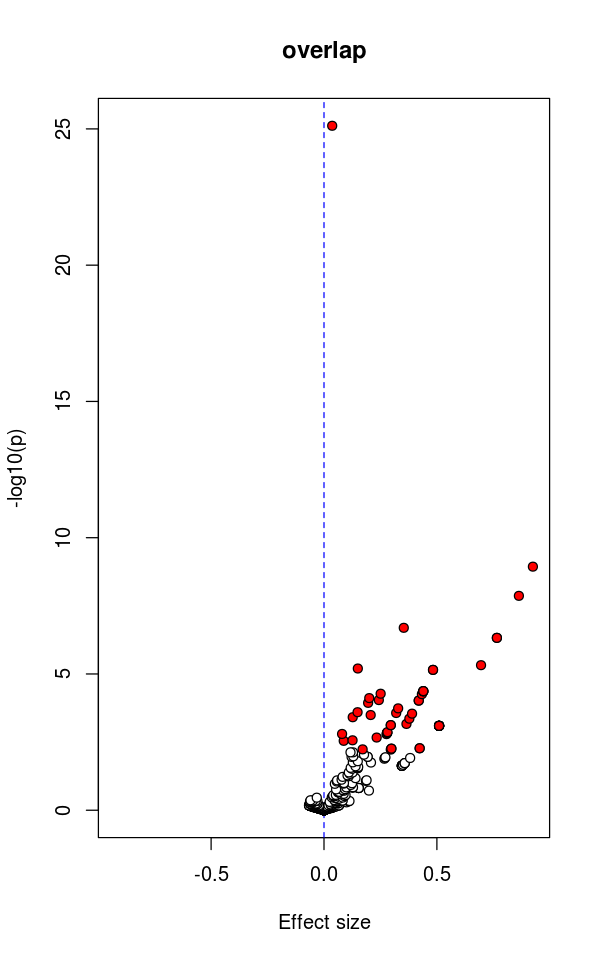

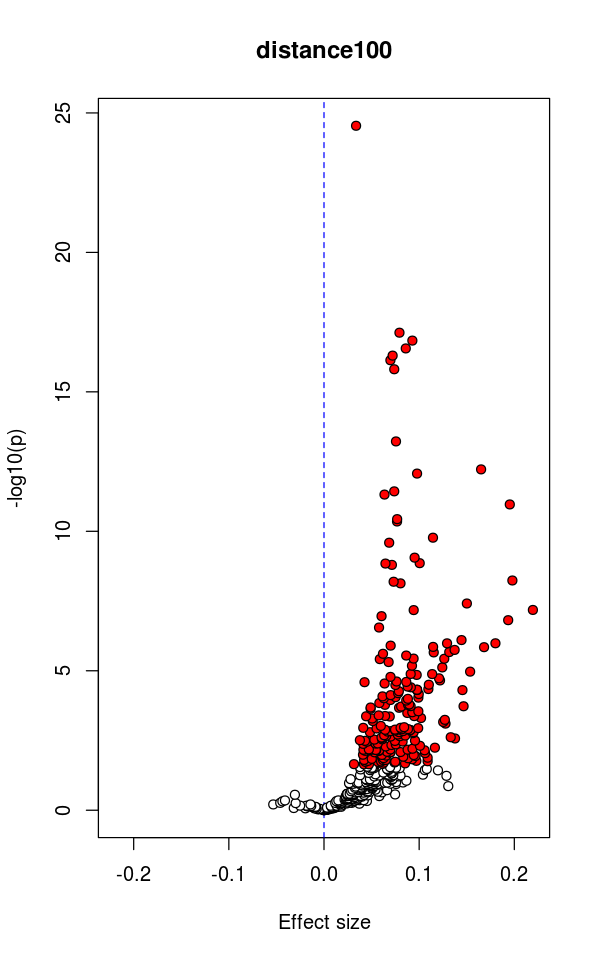

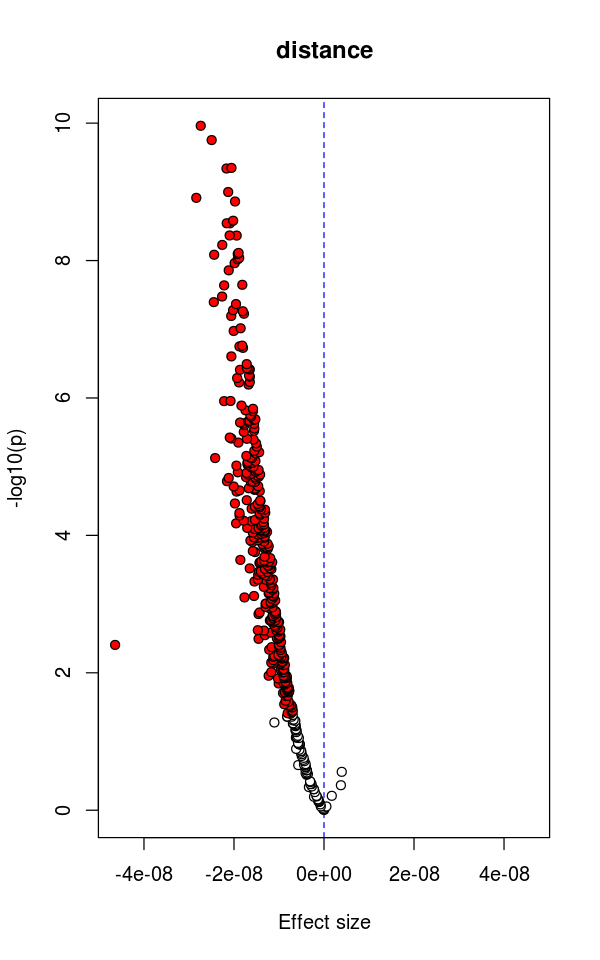

In [373]:
plot_volcano = function(x, test_overlap)
{
    toplot   = test_overlap
    toplot$x =        toplot[,paste(x, "beta", sep = ".")]
    toplot$y = -log10(toplot[,paste(x, "pval", sep = ".")])
    toplot   = toplot[order(toplot$y),]
    
    toplot$color = "#ffffff"
    
    toplot[toplot[,paste(x, "qval", sep = ".")] <= 0.05, "color"] = "#ff0000"
    
    
    xlims    = max(abs(toplot$x))
    xlims    = c(-xlims, xlims)
    
    plot(1,1, type = "n", xlim = xlims, ylim = c(0, max(toplot$y)), xlab = "Effect size", ylab = "-log10(p)", main = x)
    
    abline(v = 0, lty = "dashed", col = "#0000ff")
    
    points(x = toplot$x, y = toplot$y, pch = 21, bg = toplot$color)
}

plot_volcano("overlap"    , test_overlap)
plot_volcano("distance100", test_overlap)
plot_volcano("distance"   , test_overlap)


In [244]:
cs2motif_df = as.data.frame(rbindlist(cs2motif_list), stringsAsFactors = FALSE)
cs2motif_df = aggregate(distance ~ id + signal_id + chrom + pos + pp_snp + cs_rank, data = cs2motif_df[ cs2motif_df$motif != "atac",], FUN = min)

In [249]:
cs2motif_df$overlap = 0

cs2motif_df[cs2motif_df$distance == 0, "overlap"] = 1

summary(lm(pp_snp ~ overlap , data = cs2motif_df))$coefficients
summary(lm(pp_snp ~ distance, data = cs2motif_df[cs2motif_df$distance <= 100000,]))$coefficients


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.06556586,0.0007942988,82.545575,0.000000e+00
overlap,0.06613014,0.0068510558,9.652547,5.090134e-22


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),7.142216e-02,1.078503e-03,66.223399,0.000000e+00
distance,-2.664261e-07,4.043285e-08,-6.589347,4.480024e-11


## still holds true when I merge all TFs

In [260]:
distance_bins = data.frame(name = c("overlap", "1-100", "101-200", "201-500", "501-1000", "1001-10000", "10001-100000"), 
                           from = c(0,   1, 101, 201,  501,  1001,  10001),
                           to   = c(0, 100, 200, 500, 1000, 10000, 100000))
pp_bins       = data.frame(name = c("0-0.01", "0.01-0.1", "0.1-0.25", "0.25-0.9", "0.9-1"), 
                           from = c(0   , 0.01, 0.1 , 0.25, 0.9),
                           to   = c(0.01, 0.1 , 0.25, 0.9 , 1  ))

rownames(distance_bins)  = distance_bins$name
rownames(pp_bins      )  = pp_bins      $name
cs2motif_df$distance_bin = ""
cs2motif_df$pp_bin       = ""

for(x in distance_bins$name)
{
    from = distance_bins[x, "from"]
    to   = distance_bins[x, "to"  ]
    
    cs2motif_df[ cs2motif_df$distance >= from & cs2motif_df$distance <= to, "distance_bin"] = x
}

for(x in pp_bins$name)
{
    from = pp_bins[x, "from"]
    to   = pp_bins[x, "to"  ]
    
    cs2motif_df[ cs2motif_df$pp_snp > from & cs2motif_df$pp_snp <= to, "pp_bin"] = x
}




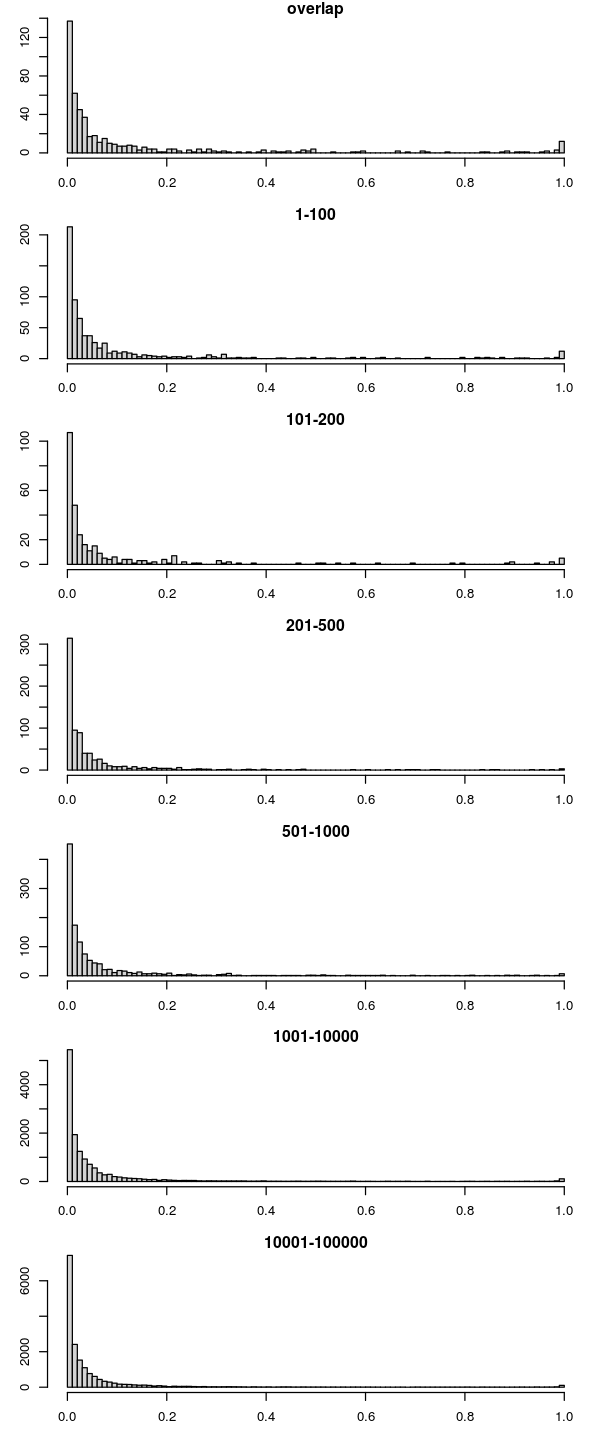

In [270]:

options(repr.plot.width = 5, repr.plot.height = 12)
layout(cbind(1:nrow(distance_bins)))

par(mar = c(3,3,1,1))

for(x in distance_bins$name)
{
    toplot = cs2motif_df[ cs2motif_df$distance_bin == x,]
    
    hist(toplot$pp_snp, breaks = (0:100) / 100, main = x)
    
}



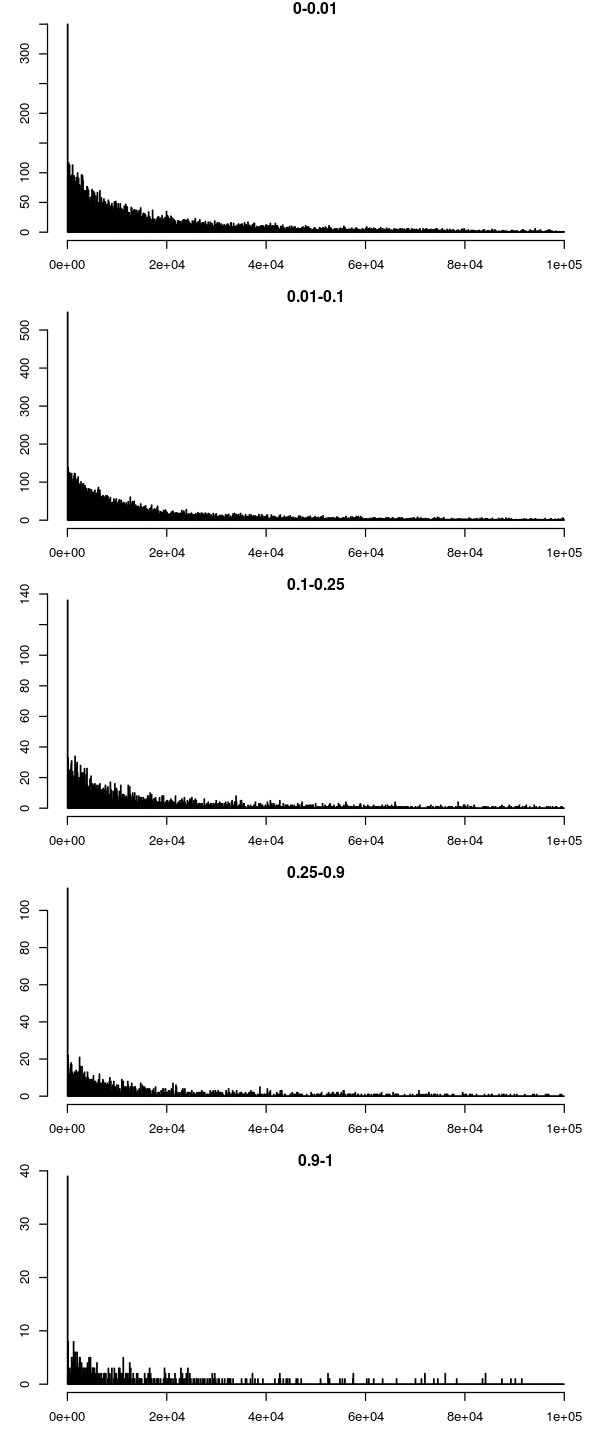

In [269]:

options(repr.plot.width = 5, repr.plot.height = 12)
layout(cbind(1:nrow(pp_bins)))

par(mar = c(3,3,1,1))

for(x in pp_bins$name)
{
    toplot = cs2motif_df[ cs2motif_df$pp_bin == x,]
    
    hist(toplot[toplot$distance <= 100000, "distance"], breaks = (0:1000) *100, main = x)
    
}


## for each signal, is the variant with the highest PPA more likely to overlap an active TFBS?
- YES

In [272]:
summary(lm(cs_rank ~ overlap, data = cs2motif_df))$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),14.082241,0.05760194,244.475120,0.000000e+00
overlap,-3.072201,0.49683329,-6.183565,6.332302e-10


## for each signal, is the variant with the highest PPA the closest to an active TFBS?
- YES

In [275]:
summary(lm(cs_rank ~ distance, data = cs2motif_df[cs2motif_df$distance <= 100000,]))$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.358893e+01,7.780621e-02,174.650915,0.000000e+00
distance,2.374719e-05,2.916938e-06,8.141138,4.043825e-16


## how many signals have their credible set variants overlapping active TFBS?

In [276]:
cs2motif_all = as.data.frame(rbindlist(cs2motif_list), stringsAsFactors = FALSE)

In [293]:
signals_to_test    = sort(unique(cs2motif_all$signal_id))
cs2motif_by_signal = lapply(signals_to_test, function(x)
{
    out = cs2motif_all[ cs2motif_all$signal_id == x,]
    return(out)
})
names(cs2motif_by_signal) = signals_to_test


In [307]:
cs2motif = as.data.frame(rbindlist(lapply(1:nrow(credible_sets), function(ii)
{
    this                   = credible_sets[ii,]
    closest                = cs2motif_by_signal[[this$signal_id]]
    closest                = closest[ closest$id == this$id,]
    closest_atac           = closest[closest$motif == "atac",]
    closest_tfbs           = closest[closest$motif != "atac",]
    mycols                 = c("motif", "distance", "overlap", "distance100", "tfbs_coord")
    closest_atac           = closest_atac[which.min(closest_atac$distance), mycols]
    closest_tfbs           = closest_tfbs[which.min(closest_tfbs$distance), mycols]
    closest_tfbs           = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], closest_tfbs)
    colnames(closest_atac) = paste("peak", colnames(closest_atac), sep = ".")
    colnames(closest_tfbs) = paste("tfbs", colnames(closest_tfbs), sep = ".")
    out                    = this
    out$cs_rank            = closest[1,"cs_rank"]
    out                    = cbind(out, closest_atac)
    out                    = cbind(out, closest_tfbs)
    
    return(out)
})), stringsAsFactors = FALSE)

fwrite(cs2motif, "pipeline/6.2.footprints_finemap/cs2motif_by_variant.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

In [334]:
str(cs2motif)

'data.frame':	37049 obs. of  20 variables:
 $ id              : chr  "VAR_1_1079866_C_G" "VAR_1_1086179_T_C" "VAR_1_1088671_C_T" "VAR_1_1089106_G_A" ...
 $ chrom           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ pos             : num  1079866 1086179 1088671 1089106 1092367 ...
 $ signal_id       : chr  "1_965800_2544414.3" "1_965800_2544414.3" "1_965800_2544414.3" "1_965800_2544414.3" ...
 $ cs_rank         : int  8 1 5 7 6 9 4 3 2 13 ...
 $ pval            : num  3.52e-19 1.92e-21 6.20e-20 8.17e-20 6.36e-20 ...
 $ pp_snp          : num  0.00396 0.67218 0.02139 0.01639 0.02097 ...
 $ peak.motif      : chr  "atac" "atac" "atac" "atac" ...
 $ peak.distance   : int  12521 6208 3716 3281 20 13 1080 3241 5387 421 ...
 $ peak.overlap    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ peak.distance100: num  0 0 0 0 1 1 0 0 0 0 ...
 $ peak.tfbs_coord : chr  "1_1092387_1094050" "1_1092387_1094050" "1_1092387_1094050" "1_1092387_1094050" ...
 $ tfbs.motif      : chr  "MA0748.2" "MA0748.2" "MA0748.2" "MA0748.2" ...

In [318]:
signal2atac                    = cs50
rownames(signal2atac)          = signal2atac$id
signal2atac$overlap_atac_peak  = ""
signal2atac$overlap_atac       = FALSE
signal2atac$overlap_atac_lead  = FALSE
signal2atac$overlap_tfbs_motif = ""
signal2atac$overlap_tfbs       = FALSE
signal2atac$overlap_tfbs_lead  = FALSE

signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$peak.overlap == 1                        , "signal_id"], "overlap_atac"     ] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$peak.overlap == 1 & cs2motif$cs_rank == 1, "signal_id"], "overlap_atac_lead"] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$tfbs.overlap == 1                        , "signal_id"], "overlap_tfbs"     ] = TRUE
signal2atac[ signal2atac$id %in% cs2motif[ cs2motif$tfbs.overlap == 1 & cs2motif$cs_rank == 1, "signal_id"], "overlap_tfbs_lead"] = TRUE

for(signal_id in signal2atac[ signal2atac$overlap_atac == TRUE, "id"])
{
    signal2atac[signal_id, "overlap_atac_peak"] = paste(sort(unique(cs2motif[ cs2motif$signal_id == signal_id & cs2motif$peak.overlap == 1, "peak.tfbs_coord"])), collapse = "; ")
}

for(signal_id in signal2atac[ signal2atac$overlap_tfbs == TRUE, "id"])
{
    signal2atac[signal_id, "overlap_tfbs_motif"] = paste(sort(unique(cs2motif[ cs2motif$signal_id == signal_id & cs2motif$tfbs.overlap == 1, "tfbs.name"])), collapse = "; ")
}

signal2atac$atac_min_distance = unlist(lapply(signal2atac$id, function(signal_id){min(cs2motif[ cs2motif$signal_id == signal_id, "peak.distance"])}))
signal2atac$tfbs_min_distance = unlist(lapply(signal2atac$id, function(signal_id){min(cs2motif[ cs2motif$signal_id == signal_id, "tfbs.distance"])}))


            overlap_tfbs
overlap_atac FALSE TRUE
       FALSE  1588    0
       TRUE    539  362

[1] 75

[1] 276

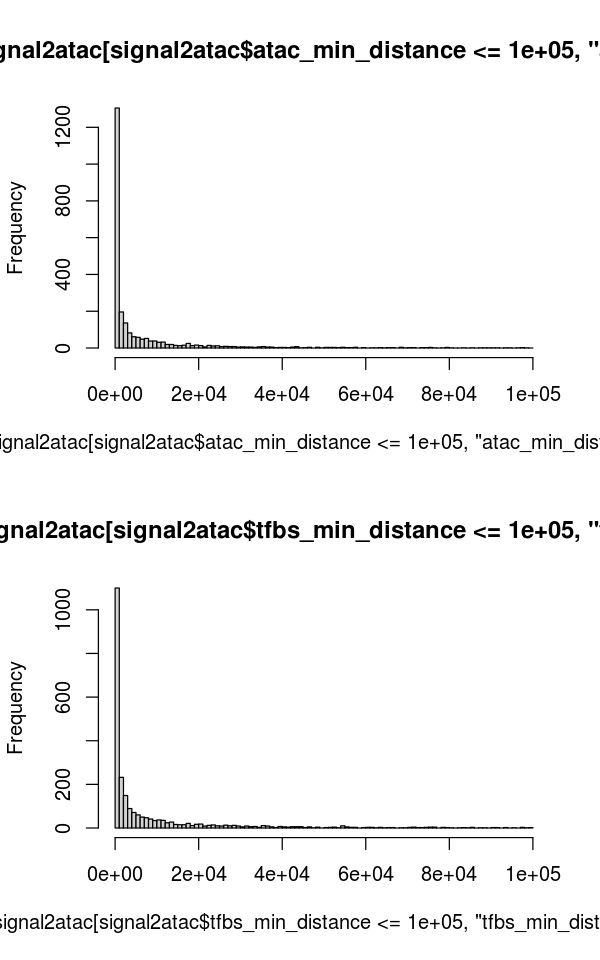

In [371]:
table(signal2atac[,c("overlap_atac", "overlap_tfbs")])

nrow(signal2atac[ signal2atac$atac_min_distance > 0 & signal2atac$atac_min_distance <= 100,])
nrow(signal2atac[ signal2atac$tfbs_min_distance > 0 & signal2atac$tfbs_min_distance <= 100,])

options(repr.plot.width = 5, repr.plot.height = 8)
layout(cbind(1:2))


hist(signal2atac[ signal2atac$atac_min_distance <= 100000, "atac_min_distance"], breaks = (0:100) * 1000)
hist(signal2atac[ signal2atac$tfbs_min_distance <= 100000, "tfbs_min_distance"], breaks = (0:100) * 1000)


# Enrichment of specific signals to be associated with TFs

In [337]:
moloc_map_list = readRDS("pipeline/2.2.moloc/moloc_map_list.rds")
signal2trait   = moloc_map_list[["som"]][["input"]]

In [394]:
enrichment_trait_tf = function(trait, motif, cs2motif_list, signal2trait)
{
    totest       = cs2motif_list[[motif]]
    signals      = rownames(signal2trait[ signal2trait[,trait] == 1,])
    totest$trait = 0
    
    totest[ totest$signal_id %in% signals, "trait"] = 1
    
    test = t.test(totest[ totest$trait == 1 & totest$distance <= 1000000, "distance"], totest[ totest$trait == 0 & totest$distance <= 1000000, "distance"])
    out  = data.frame(trait = trait, n_signals = length(signals), motif = motif, distance_trait = test$estimate[[1]], distance_rest = test$estimate[[2]], delta = test$estimate[[1]] - test$estimate[[2]], ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], pval = test$p.value)
    
    x11     = nrow(totest[ totest$trait == 1 & totest$overlap == 1,])
    x12     = nrow(totest[ totest$trait == 1 & totest$overlap == 0,])
    x21     = nrow(totest[ totest$trait == 0 & totest$overlap == 1,])
    x22     = nrow(totest[ totest$trait == 0 & totest$overlap == 0,])
    totest2 = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test2   = fisher.test(totest2)
    out2    = data.frame(x11_overlap = x11, x12_overlap = x12, x21_overlap = x21, x22_overlap = x22, estimate_overlap = test2$estimate, ci1_overlap = test2$conf.int[[1]], ci2_overlap = test2$conf.int[[2]], pval_overlap = test2$p.value)
    out     = cbind(out, out2)
    
    x11     = nrow(totest[ totest$trait == 1 & totest$distance100 == 1,])
    x12     = nrow(totest[ totest$trait == 1 & totest$distance100 == 0,])
    x21     = nrow(totest[ totest$trait == 0 & totest$distance100 == 1,])
    x22     = nrow(totest[ totest$trait == 0 & totest$distance100 == 0,])
    totest2 = matrix(c(x11, x12, x21, x22), nrow = 2, byrow = TRUE)
    test2   = fisher.test(totest2)
    out3    = data.frame(x11_dist100 = x11, x12_dist100 = x12, x21_dist100 = x21, x22_dist100 = x22, estimate_dist100 = test2$estimate, ci1_dist100 = test2$conf.int[[1]], ci2_dist100 = test2$conf.int[[2]], pval_dist100 = test2$p.value)
    out     = cbind(out, out3)
    
    return(out)
}
   
trait2tf_enrichment = as.data.frame(rbindlist(lapply(colnames(signal2trait), function(trait)
{
    as.data.frame(rbindlist(lapply(names(cs2motif_list), function(motif)
    {
        enrichment_trait_tf(trait, motif, cs2motif_list, signal2trait)
    })), stringsAsFactors = FALSE)    
})), stringsAsFactors = FALSE) 

trait2tf = merge(tfbs[,c("motif", "name", "gene_id", "gene_name")], trait2tf_enrichment, by = "motif")
trait2tf = merge(manifest[,c("id", "name")]                       , trait2tf           , by.x = "id", by.y = "trait", suffixes = c("_trait", "_motif"))

trait2tf$qval         = p.adjust(trait2tf$pval        , method = "BH")
trait2tf$qval_overlap = p.adjust(trait2tf$pval_overlap, method = "BH")
trait2tf$qval_dist100 = p.adjust(trait2tf$pval_dist100, method = "BH")

fwrite(trait2tf, "pipeline/6.2.footprints_finemap/trait2tf_enrichment.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


In [393]:
1+1

[1] 2

In [391]:
cs2motif_list[[1]]

id,signal_id,chrom,pos,pval,pp_snp,cs_rank,motif,tfbs_coord,peak,tfbs_bound,from,to,distance,overlap,distance100
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
VAR_1_10357806_G_C,1_9830927_10934579.2,1,10357806,5.701000e-24,0.999896828,1,MA0002.2,1_10346430_10346441,chr1_10346199_10347220,0.7297297,10346430,10346441,11365,0,0
VAR_1_107056847_G_A,1_106956847_107177386.1,1,107056847,3.732706e-15,0.013228344,13,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2232240,0,0
VAR_1_107057323_C_T,1_106956847_107177386.1,1,107057323,1.625077e-15,0.030106640,11,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2231764,0,0
VAR_1_107057424_C_A,1_106956847_107177386.1,1,107057424,6.127183e-16,0.080134375,3,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2231663,0,0
VAR_1_107058019_G_A,1_106956847_107177386.1,1,107058019,5.642166e-16,0.085895048,2,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2231068,0,0
VAR_1_107058600_G_A,1_106956847_107177386.1,1,107058600,1.759843e-15,0.027979593,12,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2230487,0,0
VAR_1_107062025_C_T,1_106956847_107177386.1,1,107062025,1.609785e-15,0.030545238,9,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2227062,0,0
VAR_1_107067308_C_T,1_106956847_107177386.1,1,107067308,1.057767e-16,0.440692642,1,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2221779,0,0
VAR_1_107071905_A_G,1_106956847_107177386.1,1,107071905,1.036154e-15,0.047039147,6,MA0002.2,1_109289087_109289098,chr1_109288932_109290283,0.7760618,109289087,109289098,2217182,0,0


In [381]:
str(tfbs)


'data.frame':	429 obs. of  12 variables:
 $ motif    : chr  "MA0002.2" "MA0003.4" "MA0007.3" "MA0017.2" ...
 $ infile   : chr  "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/RUNX1_MA0002.2.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/TFAP2A_MA0003.4.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/Ar_MA0007.3.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/NR2F1_MA0017.2.txt" ...
 $ base_id  : chr  "MA0002" "MA0003" "MA0007" "MA0017" ...
 $ version  : num  2 4 3 2 4 3 2 2 1 2 ...
 $ id       : chr  "9230" "9231" "10649" "9245" ...
 $ name     : chr  "RUNX1" "TFAP2A" "AR" "NR2F1" ...
 $ prot_acc : chr  "Q01196" "P05549" "P10275" "P10589" ...
 $ gene_id  : chr  "ENSG00000159216.18_7" "ENSG00000137203.14_6" "ENSG00000169083.17_8" "ENSG00000175745.14_6" ...
 $ gene_name: chr  "RUNX1" "TFAP2A" "AR" "NR2F1" ...
 $ bed      : chr  "pipeline/6.2.footprints_finemap/intersect/input/MA0002.2.bed"

In [339]:
head(signal2trait)

,biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,categorical-20003-both_sexes-1140866738,categorical-20003-both_sexes-1140879802,categorical-20003-both_sexes-1141146234,⋯,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,icd10-I26-both_sexes,icd10-I48-both_sexes,phecode-401-both_sexes,phecode-411.2-both_sexes,phecode-411.4-both_sexes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1_965800_2544414.1,0,0,0,0,0,0,0,0,0,0,⋯,1,0,1,0,0,0,0,0,0,0
1_965800_2544414.2,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1_965800_2544414.3,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1_965800_2544414.4,0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1_965800_2544414.5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
1_965800_2544414.6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [335]:
str(signal2atac)

'data.frame':	2489 obs. of  28 variables:
 $ chrom             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pos               : int  1086179 1481348 1584192 1592638 1687152 2725475 3327032 6263792 6278414 6678864 ...
 $ som               : int  102 198 214 163 366 163 272 214 73 391 ...
 $ id                : chr  "1_965800_2544414.3" "1_965800_2544414.2" "1_965800_2544414.6" "1_965800_2544414.5" ...
 $ locus             : chr  "1_965800_2544414" "1_965800_2544414" "1_965800_2544414" "1_965800_2544414" ...
 $ cluster           : int  18 21 14 11 17 11 16 14 19 27 ...
 $ class             : chr  "V102" "V198" "V214" "V163" ...
 $ traits            : chr  "biomarkers-30680-both_sexes-irnt" "biomarkers-30600-both_sexes-irnt" "continuous-PP-both_sexes-combined_medadj_irnt" "continuous-21001-both_sexes-irnt" ...
 $ traits_n          : int  1 1 1 1 2 1 4 1 1 3 ...
 $ eqtls             : chr  "" "ENSG00000205090.9_5:0" "ENSG00000215914.4_3:0;ENSG00000215914.4_3:1;ENSG00000228594.4_8:0;ENST00000378675.7_

In [317]:
str(cs2motif)

'data.frame':	37049 obs. of  20 variables:
 $ id              : chr  "VAR_1_1079866_C_G" "VAR_1_1086179_T_C" "VAR_1_1088671_C_T" "VAR_1_1089106_G_A" ...
 $ chrom           : num  1 1 1 1 1 1 1 1 1 1 ...
 $ pos             : num  1079866 1086179 1088671 1089106 1092367 ...
 $ signal_id       : chr  "1_965800_2544414.3" "1_965800_2544414.3" "1_965800_2544414.3" "1_965800_2544414.3" ...
 $ cs_rank         : int  8 1 5 7 6 9 4 3 2 13 ...
 $ pval            : num  3.52e-19 1.92e-21 6.20e-20 8.17e-20 6.36e-20 ...
 $ pp_snp          : num  0.00396 0.67218 0.02139 0.01639 0.02097 ...
 $ peak.motif      : chr  "atac" "atac" "atac" "atac" ...
 $ peak.distance   : int  12521 6208 3716 3281 20 13 1080 3241 5387 421 ...
 $ peak.overlap    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ peak.distance100: num  0 0 0 0 1 1 0 0 0 0 ...
 $ peak.tfbs_coord : chr  "1_1092387_1094050" "1_1092387_1094050" "1_1092387_1094050" "1_1092387_1094050" ...
 $ tfbs.motif      : chr  "MA0748.2" "MA0748.2" "MA0748.2" "MA0748.2" ...

In [287]:
str(tfbs)

'data.frame':	429 obs. of  12 variables:
 $ motif    : chr  "MA0002.2" "MA0003.4" "MA0007.3" "MA0017.2" ...
 $ infile   : chr  "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/RUNX1_MA0002.2.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/TFAP2A_MA0003.4.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/Ar_MA0007.3.txt" "/frazer01/projects/CARDIPS/analysis/footprint_eqtl/bound_peak/motif/NR2F1_MA0017.2.txt" ...
 $ base_id  : chr  "MA0002" "MA0003" "MA0007" "MA0017" ...
 $ version  : num  2 4 3 2 4 3 2 2 1 2 ...
 $ id       : chr  "9230" "9231" "10649" "9245" ...
 $ name     : chr  "RUNX1" "TFAP2A" "AR" "NR2F1" ...
 $ prot_acc : chr  "Q01196" "P05549" "P10275" "P10589" ...
 $ gene_id  : chr  "ENSG00000159216.18_7" "ENSG00000137203.14_6" "ENSG00000169083.17_8" "ENSG00000175745.14_6" ...
 $ gene_name: chr  "RUNX1" "TFAP2A" "AR" "NR2F1" ...
 $ bed      : chr  "pipeline/6.2.footprints_finemap/intersect/input/MA0002.2.bed"